## Quora Question Pair Similarity

### Business Problem 

Problem Statement:
    1. Identify which questions asked on Quora are duplicates of questions that have already been asked.
    2. This could be useful to instantly provide answers to questions that have already been answered.
    3. We are given with a task of predicting whether a pair of questions are duplicates or not.
    
    
Useful URL's:
    - Source : https://www.kaggle.com/c/quora-question-pairs 
    - Discussions: https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments

### Real World Business Objectives and constraints

1. The cost of a mis-classification can be very high.
2. Required probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially import

### Date Overview 


- Data will be in a file Train.csv 
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate 
- Size of Train.csv - 60MB 
- Number of rows in Train.csv = 404,290


###### Example Data Point 

- id, qid1, qid2, question1, question2, is_duplicate
- "0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?"
- "0","1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?"

### Machine Learning Mapping 

###### Type of Problem 

- It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.

###### Performance Metrics 

- log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
- Binary Confusion Matrix

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import time 
import warnings

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE

from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

warnings.filterwarnings("ignore")
import sys
import os 
from tqdm import tqdm


# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

import sqlite3
from sqlalchemy import create_engine # database connection
import csv
warnings.filterwarnings("ignore")
import datetime as dt

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



###### Read Data 

In [2]:
df = pd.read_csv('data/train.csv')

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


###### Distribution of data points among output class

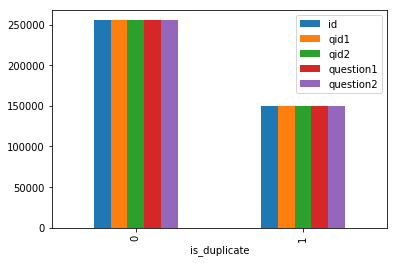

In [5]:
df.groupby('is_duplicate').count().plot.bar()

In [6]:
### 0 indicates question pairs are not duplicate 
### 1 indicates question pairs are duplicate

print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


In [7]:
print (df[df.is_duplicate == 0].is_duplicate.count())
print (df[df.is_duplicate == 1].is_duplicate.count())


255027
149263


In [8]:
df.qid1.value_counts()

8461      50
14110     48
25984     47
20628     47
1749      47
4951      46
27618     45
14772     45
58173     44
3595      42
9006      42
19200     42
2559      42
1885      41
71948     41
14111     41
6551      40
24296     40
51617     39
31868     39
21712     39
6099      38
7529      38
19199     37
47485     36
17761     36
6799      36
10859     36
10433     36
2438      35
          ..
405092     1
403045     1
11940      1
1697       1
128671     1
130718     1
126620     1
116377     1
112279     1
108181     1
99985      1
79495      1
71299      1
67201      1
456319     1
454268     1
439927     1
441974     1
437876     1
431731     1
433778     1
427633     1
423535     1
425582     1
421484     1
415339     1
411241     1
413288     1
409190     1
524288     1
Name: qid1, Length: 290654, dtype: int64

In [9]:
df.qid2.value_counts()

30782     120
2559      115
4044      100
2561       71
17978      66
14376      59
28764      59
38         52
28133      52
18531      51
20190      49
6275       46
1772       46
24555      45
4367       44
60274      44
22064      43
30647      43
6100       42
6749       42
11264      42
4507       41
2921       41
7801       41
691        40
41885      40
4416       40
9262       40
12639      40
18355      40
         ... 
216266      1
206023      1
212164      1
197827      1
60606       1
42167       1
527762      1
33971       1
36018       1
38065       1
537593      1
31916       1
21673       1
23720       1
15524       1
3234        1
5281        1
531616      1
128157      1
531452      1
119961      1
122008      1
107671      1
111765      1
113812      1
99475       1
105616      1
85130       1
525311      1
288755      1
Name: qid2, Length: 299364, dtype: int64

In [10]:
## From above value counts we can see that there are questionId's with more than 1 number:: (Repeated multiple times)

###### Lets look into unique number of questions

In [11]:
qids = pd.Series(df.qid1.tolist() + df.qid2.tolist())

unique_qs = len(np.unique(qids))

qs_morethan_onetime = np.sum(qids.value_counts() > 1)

print ("Total Number of Unique Qstns : ", unique_qs)

print ("Number of Unique questions that appear more than one item :", qs_morethan_onetime, " : ", 
      (qs_morethan_onetime/unique_qs) * 100)

print("Max number of times a single Qstn is repeated : ", max(qids.value_counts()))

q_vals = qids.value_counts()
q_vals = q_vals.values

q_vals

Total Number of Unique Qstns :  537933
Number of Unique questions that appear more than one item : 111780  :  20.77953945937505
Max number of times a single Qstn is repeated :  157


array([157, 120, 111, ...,   1,   1,   1], dtype=int64)

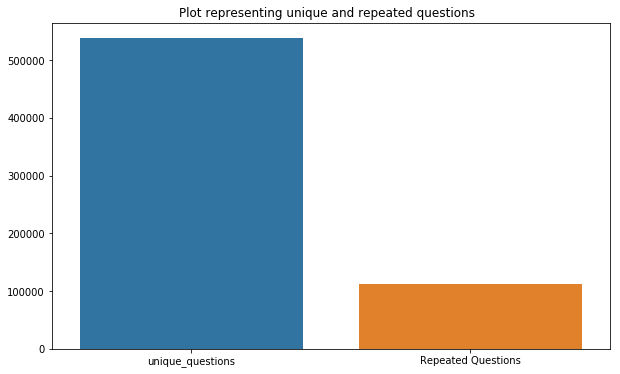

In [12]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

###### Check for repeated pairs of questions

In [13]:
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


Maximum number of times a single question is repeated: 157



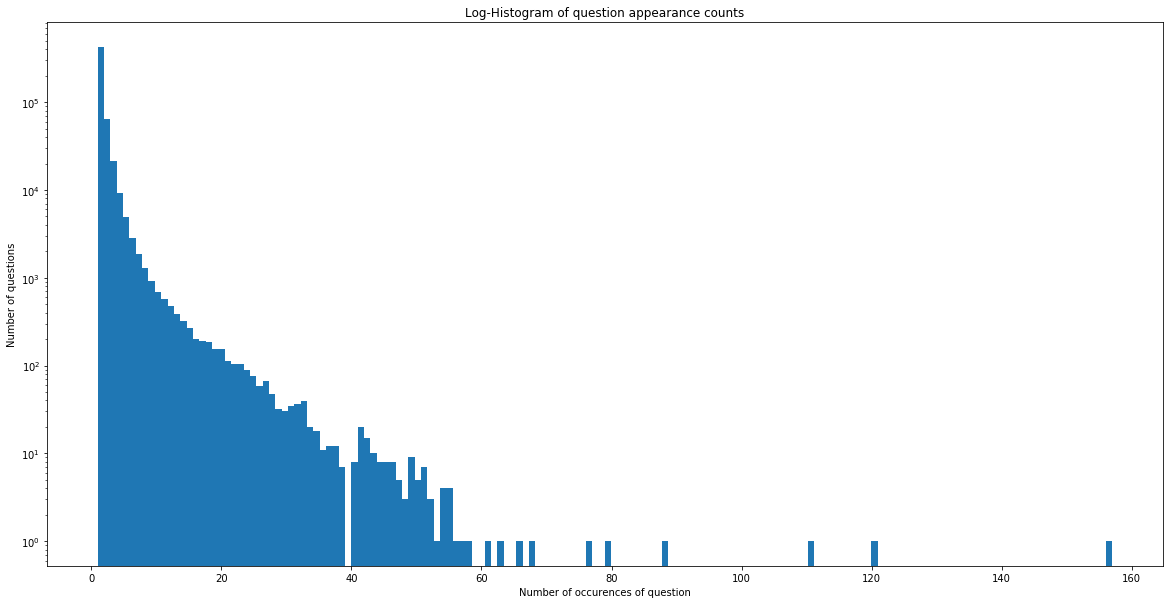

In [14]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In [15]:
### Few qids occur more than 60 times.
### There are huge number of qids that occur in between 0-40

###### Check for null  values 

In [16]:
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [17]:
## There are 3 rows with Null values.. Filling with empty string ""

df = df.fillna(" ")
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


##### Let us create/extract additional features from existing features 

 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [18]:
## New Features 

df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')

df['q1len'] = df['question1'].str.len() 
df['q2len'] = df['question2'].str.len()

df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_Common(row):
    '''
    Common words in Q1 and Q2
    '''
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
df['word_Common'] = df.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    '''
    Total number of words in Q1 + Q2
    '''
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    ''' 
    Ratio of Word_Common / Total_Words
    '''
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [19]:
### Some Outcomes of above table 

print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 66
Number of Questions with minimum length [question2] : 22


#### Lets look into word_share

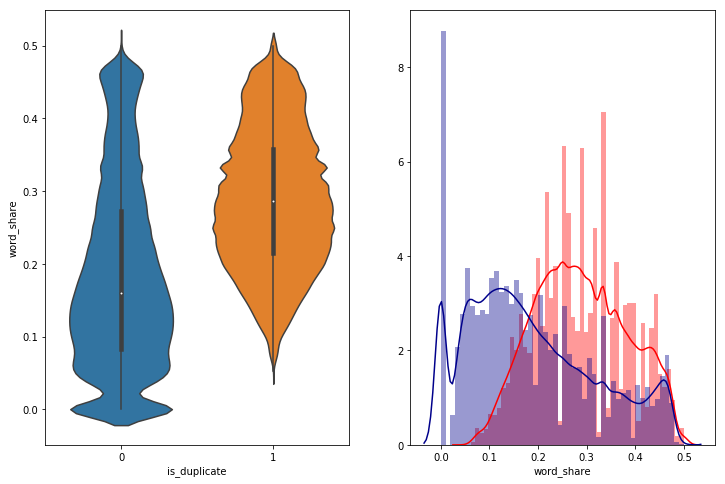

In [20]:
### Lets Plot  word_Share feature using boxplots and violin plot

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'darkblue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity.

- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

#### Feature: word_common

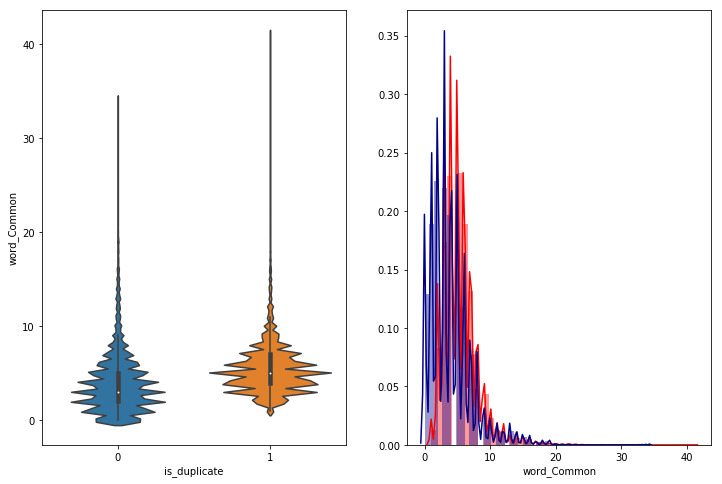

In [21]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'darkblue' )
plt.show()

In [22]:
### Distribution of word_common is highly overlapping with similar and non-similar pair of questions

##### Text Preprocessing

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [23]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x


####  Advanced Feature Extraction (NLP and Fuzzy Features)

Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>




- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [24]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [25]:
%%time

if os.path.isfile('data/nlp_features_train.csv'):
    df = pd.read_csv("data/nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("data/train.csv")
    df = extract_features(df)
    df.to_csv("data/nlp_features_train.csv", index=False)
df.head(2)

Wall time: 17 s


##### Analysis of extracted  features 


###### Plotting wordclod 
   
   - Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
   - We can observe the most frequent occuring words

In [26]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
# np.savetxt('data/train_p.txt', p, delimiter=' ', fmt='%s')
# np.savetxt('data/train_n.txt', n, delimiter=' ', fmt='%s')


Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [27]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'data/train_p.txt')).read()
textn_w = open(path.join(d, 'data/train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193130


Word Cloud for Duplicate Question pairs


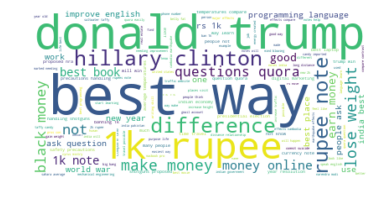

Wall time: 14.9 s


In [28]:
%%time

wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


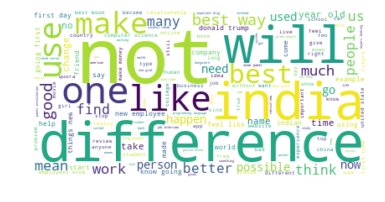

Wall time: 37.7 s


In [29]:
%%time

wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

###### Lets do pair plot for some features

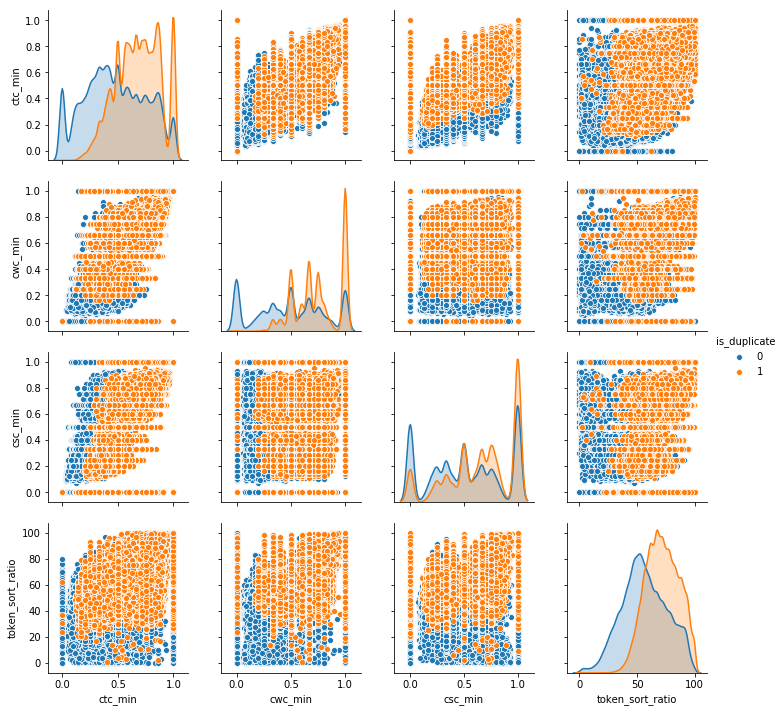

Wall time: 1min 38s


In [30]:
%%time

n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], 
             hue='is_duplicate', 
             vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

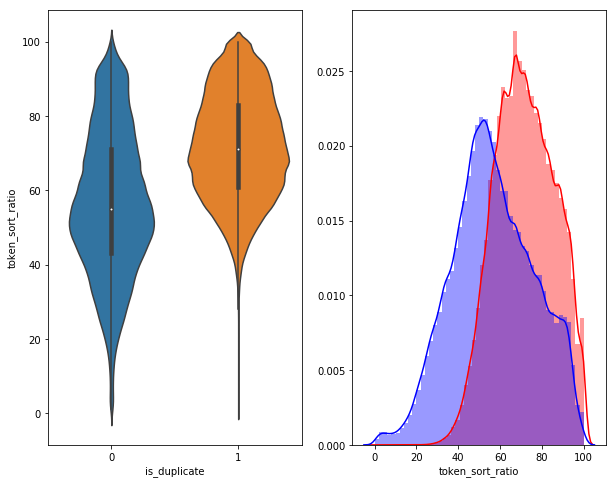

In [31]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

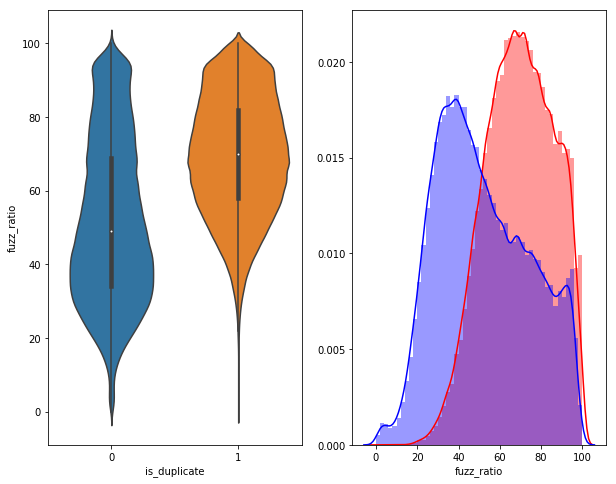

In [32]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

#### Visualize using TSNE

In [33]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [34]:
%%time

tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.139s...
[t-SNE] Computed neighbors for 5000 samples in 0.825s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.490s
[t-SNE] Iteration 50: error = 81.2911148, gradient norm = 0.0457501 (50 iterations in 6.045s)
[t-SNE] Iteration 100: error = 70.6044159, gradient norm = 0.0086692 (50 iterations in 4.128s)
[t-SNE] Iteration 150: error = 68.9124908, gradient norm = 0.0056016 (50 iterations in 4.241s)
[t-SNE] Iteration 200: error = 68.1010742, gradient norm = 0.0047585 (50 iterations in 4.537s)
[t-SNE] Iteration 250: error = 67.5907974, gradient norm = 0.0033576

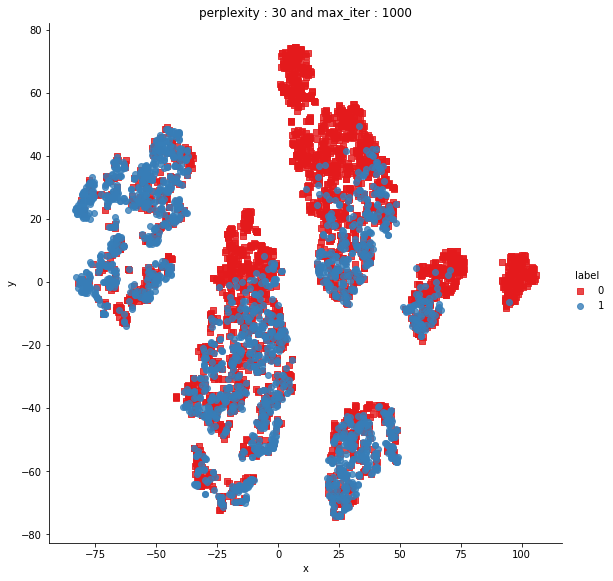

Wall time: 830 ms


In [35]:
%%time 

df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [36]:
%%time 

from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.029s...
[t-SNE] Computed neighbors for 5000 samples in 0.825s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.454s
[t-SNE] Iteration 50: error = 80.5316772, gradient norm = 0.0296611 (50 iterations in 20.360s)
[t-SNE] Iteration 100: error = 69.3815765, gradient norm = 0.0033166 (50 iterations in 10.847s)
[t-SNE] Iteration 150: error = 67.9724655, gradient norm = 0.0018542 (50 iterations in 10.109s)
[t-SNE] Iteration 200: error = 67.4176865, gradient norm = 0.0012513 (50 iterations in 9.617s)
[t-SNE] Iteration 250: error = 67.1036377, gradient norm = 0.0009

In [37]:
%%time

trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

Wall time: 9.78 s


##### Featurizing text with tfidf weighted word-vectors

In [38]:


df = pd.read_csv("data/train.csv")
 

df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [39]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

Wall time: 20.5 s


- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [40]:
%%time
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 384])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


100%|██████████| 404290/404290 [1:57:29<00:00, 57.35it/s]  


Wall time: 1h 57min 32s


In [41]:
%%time 
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 384])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 404290/404290 [1:44:40<00:00, 64.37it/s]  


Wall time: 1h 44min 40s


In [42]:
%%time
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('data/nlp_features_train.csv'):
    dfnlp = pd.read_csv("data/nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('data/df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("data/df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

Wall time: 13.3 s


In [43]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [44]:
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [45]:
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [46]:
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,121.929927,100.083900,72.497894,115.641800,-48.370870,34.619058,-172.057787,-92.502617,113.223315,50.562441,...,12.397642,40.909519,8.150261,-15.170692,18.007709,6.166999,-30.124163,3.700902,-1.757693,-1.818058
1,-78.070939,54.843781,82.738482,98.191872,-51.234859,55.013510,-39.140730,-82.692352,45.161489,-9.556289,...,-21.987077,-12.389279,20.667979,2.202714,-17.142454,-5.880972,-10.123963,-4.890663,-13.018389,-5.219310
2,-5.355015,73.671810,14.376365,104.130241,1.433537,35.229116,-148.519385,-97.124595,41.972195,50.948731,...,3.027700,14.025767,-2.960312,-3.206544,4.355141,2.936152,-20.199555,9.816351,11.894366,-8.798819
3,5.778359,-34.712038,48.999631,59.699204,40.661263,-41.658731,-36.808594,24.170655,0.235600,-29.407290,...,13.100007,1.405670,-1.891076,-7.882638,18.000561,12.106918,-10.507835,5.243834,10.158340,5.886351
4,51.138220,38.587312,123.639488,53.333041,-47.062739,37.356212,-298.722753,-106.421119,106.248914,65.880707,...,13.906532,43.461721,11.519207,-22.468284,45.431128,8.161224,-35.373910,7.728865,9.592849,5.447336


In [47]:
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,125.983301,95.636485,42.114702,95.449980,-37.386295,39.400078,-148.116070,-87.851475,110.371966,62.272814,...,16.165592,33.030668,7.019996,-14.793959,15.437511,8.199658,-25.070834,1.571619,1.603738,0.305645
1,-106.871904,80.290331,79.066297,59.302092,-42.175328,117.616655,-144.364237,-127.131513,22.962533,25.397575,...,-4.901128,-4.565393,41.520751,-0.727564,-16.413776,-7.373778,2.638877,-7.403457,2.703070,0.408040
2,7.072875,15.513378,1.846914,85.937583,-33.808811,94.702337,-122.256856,-114.009530,53.922293,60.131814,...,8.359966,-2.165985,10.936580,-16.531660,14.681230,15.633759,-1.210901,14.183826,11.703135,10.148075
3,39.421531,44.136989,-24.010929,85.265863,-0.339022,-9.323137,-60.499651,-37.044763,49.407848,-23.350150,...,3.311411,3.788879,13.398598,-6.592596,6.437365,5.993293,2.732392,-3.727647,5.614115,6.023693
4,31.950101,62.854106,1.778164,36.218768,-45.130875,66.674880,-106.342341,-22.901008,59.835938,62.663961,...,-2.403870,11.991204,8.088483,-15.090201,8.375166,1.727225,-6.601129,11.317413,11.544603,2.478689


In [48]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 384
Number of features in question2 w2v  dataframe : 384
Number of features in final dataframe  : 797


In [49]:
%%time
# storing the final features to csv file
if not os.path.isfile('data/final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('data/final_features.csv')

Wall time: 74.8 ms


### Machine Learning Models 

In [50]:
%%time
#Creating db file from csv
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('data/final_features.csv', 
                          names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max',
                                 'ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len',
                                 'token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio',
                                 'longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words',
                                 'q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2',
                                 '0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x',
                                 '13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x',
                                 '24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x',
                                 '35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x',
                                 '46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x',
                                 '57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x',
                                 '68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x',
                                 '79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x',
                                 '90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x',
                                 '101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x',
                                 '111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x',
                                 '121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x',
                                 '131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x',
                                 '141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x',
                                 '151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x',
                                 '161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x',
                                 '171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x',
                                 '181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x',
                                 '191_x','192_x','193_x','194_x','195_x','196_x','197_x','198_x','199_x','200_x',
                                 '201_x','202_x','203_x','204_x','205_x','206_x','207_x','208_x','209_x','210_x',
                                 '211_x','212_x','213_x','214_x','215_x','216_x','217_x','218_x','219_x','220_x',
                                 '221_x','222_x','223_x','224_x','225_x','226_x','227_x','228_x','229_x','230_x',
                                 '231_x','232_x','233_x','234_x','235_x','236_x','237_x','238_x','239_x','240_x',
                                 '241_x','242_x','243_x','244_x','245_x','246_x','247_x','248_x','249_x','250_x',
                                 '251_x','252_x','253_x','254_x','255_x','256_x','257_x','258_x','259_x','260_x',
                                 '261_x','262_x','263_x','264_x','265_x','266_x','267_x','268_x','269_x','270_x',
                                 '271_x','272_x','273_x','274_x','275_x','276_x','277_x','278_x','279_x','280_x',
                                 '281_x','282_x','283_x','284_x','285_x','286_x','287_x','288_x','289_x','290_x',
                                 '291_x','292_x','293_x','294_x','295_x','296_x','297_x','298_x','299_x','300_x',
                                 '301_x','302_x','303_x','304_x','305_x','306_x','307_x','308_x','309_x','310_x',
                                 '311_x','312_x','313_x','314_x','315_x','316_x','317_x','318_x','319_x','320_x',
                                 '321_x','322_x','323_x','324_x','325_x','326_x','327_x','328_x','329_x','330_x',
                                 '331_x','332_x','333_x','334_x','335_x','336_x','337_x','338_x','339_x','340_x',
                                 '341_x','342_x','343_x','344_x','345_x','346_x','347_x','348_x','349_x','350_x',
                                 '351_x','352_x','353_x','354_x','355_x','356_x','357_x','358_x','359_x','360_x',
                                 '361_x','362_x','363_x','364_x','365_x','366_x','367_x','368_x','369_x','370_x',
                                 '371_x','372_x','373_x','374_x','375_x','376_x','377_x','378_x','379_x','380_x',
                                 '381_x','382_x','383_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y',
                                 '10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y',
                                 '22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y',
                                 '34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y',
                                 '46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y',
                                 '58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y',
                                 '70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y',
                                 '82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y',
                                 '94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y',
                                 '105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y',
                                 '115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y',
                                 '125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y',
                                 '135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y',
                                 '145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y',
                                 '155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y',
                                 '165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y',
                                 '175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y',
                                 '185_y','186_y','187_y','188_y','189_y','190_y','191_y','192_y','193_y','194_y',
                                 '195_y','196_y','197_y','198_y','199_y','200_y','201_y','202_y','203_y','204_y',
                                 '205_y','206_y','207_y','208_y','209_y','210_y','211_y','212_y','213_y','214_y',
                                 '215_y','216_y','217_y','218_y','219_y','220_y','221_y','222_y','223_y','224_y',
                                 '225_y','226_y','227_y','228_y','229_y','230_y','231_y','232_y','233_y','234_y',
                                 '235_y','236_y','237_y','238_y','239_y','240_y','241_y','242_y','243_y','244_y',
                                 '245_y','246_y','247_y','248_y','249_y','250_y','251_y','252_y','253_y','254_y',
                                 '255_y','256_y','257_y','258_y','259_y','260_y','261_y','262_y','263_y','264_y',
                                 '265_y','266_y','267_y','268_y','269_y','270_y','271_y','272_y','273_y','274_y',
                                 '275_y','276_y','277_y','278_y','279_y','280_y','281_y','282_y','283_y','284_y',
                                 '285_y','286_y','287_y','288_y','289_y','290_y','291_y','292_y','293_y','294_y',
                                 '295_y','296_y','297_y','298_y','299_y','300_y','301_y','302_y','303_y','304_y',
                                 '305_y','306_y','307_y','308_y','309_y','310_y','311_y','312_y','313_y','314_y',
                                 '315_y','316_y','317_y','318_y','319_y','320_y','321_y','322_y','323_y','324_y',
                                 '325_y','326_y','327_y','328_y','329_y','330_y','331_y','332_y','333_y','334_y',
                                 '335_y','336_y','337_y','338_y','339_y','340_y','341_y','342_y','343_y','344_y',
                                 '345_y','346_y','347_y','348_y','349_y','350_y','351_y','352_y','353_y','354_y',
                                 '355_y','356_y','357_y','358_y','359_y','360_y','361_y','362_y','363_y','364_y',
                                 '365_y','366_y','367_y','368_y','369_y','370_y','371_y','372_y','373_y','374_y',
                                 '375_y','376_y','377_y','378_y','379_y','380_y','381_y','382_y','383_y'], 
                          chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

Wall time: 31.1 ms


In [51]:
%%time
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

Wall time: 998 µs
Parser   : 234 ms


In [52]:
%%time
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data
Wall time: 909 ms


In [53]:
%%time
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

Wall time: 5h 16min 32s


In [54]:
%%time

# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

Wall time: 12h 7min 22s


In [55]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
1,0.0,0.0,0.999980000399992,0.624992187597655,0.49999500005,0.294115916965194,0.0,1.0,7.0,13.5,...,14.1778820492327,34.6317745149136,11.5394680649042,0.985956743359566,8.13514749705792,-1.0410341322422,-24.6067917793989,4.86574004590511,23.3423631601036,9.75233016721904
2,0.799984000319994,0.799984000319994,0.0,0.0,0.499993750078124,0.444439506227709,1.0,0.0,1.0,8.5,...,15.7091518640518,24.2051899135113,24.4179438352585,-3.58967749588191,9.96890692412853,-9.48604953289032,-3.22985222935677,-16.4509043693542,17.6602695584297,2.79892398416996
3,0.999900009999,0.499975001249937,0.999966667777741,0.749981250468738,0.799984000319994,0.799984000319994,1.0,1.0,0.0,5.0,...,-0.504226684570313,-2.82265257835388,0.0645252466201782,-1.26571014523506,-1.97766007483006,3.18229854106903,8.34250688552856,5.64245688915253,1.4406661093235,2.60324847698212
4,0.999966667777741,0.749981250468738,0.999950002499875,0.499987500312492,0.999980000399992,0.624992187597655,0.0,1.0,3.0,6.5,...,5.23849506303668,4.00744867324829,12.2985890507698,-6.64424958080053,12.1886614188552,0.637879364192486,2.3652577213943,18.5329880630597,-2.19820787757635,2.62543495744467
5,0.749993750052083,0.499997222237654,0.416663194473379,0.384612426058261,0.499998214292092,0.399998857146122,0.0,0.0,7.0,31.5,...,37.5486728623509,35.0503353998065,-6.20921673066914,-13.9614988584071,26.1535188718699,11.1590668708086,-26.4377608997747,36.3677108697593,9.24239572137594,3.89642868936062


##### Converting Strings to numerics

In [104]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
for i in cols:
    #data[i] = data[i].apply(pd.to_numeric)
    data[i] = pd.to_numeric(data[i], errors='ignore', downcast='float')
    #data['cwc_min'] = pd.to_numeric(data['cwc_min'], errors='ignore', downcast='float')

data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
1,0.0,0.0,0.999980000399992,0.624992187597655,0.49999500005,0.294115916965194,0.0,1.0,7.0,13.5,...,14.1778820492327,34.6317745149136,11.5394680649042,0.985956743359566,8.13514749705792,-1.0410341322422,-24.6067917793989,4.86574004590511,23.3423631601036,9.75233016721904
2,0.799984000319994,0.799984000319994,0.0,0.0,0.499993750078124,0.444439506227709,1.0,0.0,1.0,8.5,...,15.7091518640518,24.2051899135113,24.4179438352585,-3.58967749588191,9.96890692412853,-9.48604953289032,-3.22985222935677,-16.4509043693542,17.6602695584297,2.79892398416996
3,0.999900009999,0.499975001249937,0.999966667777741,0.749981250468738,0.799984000319994,0.799984000319994,1.0,1.0,0.0,5.0,...,-0.504226684570313,-2.82265257835388,0.0645252466201782,-1.26571014523506,-1.97766007483006,3.18229854106903,8.34250688552856,5.64245688915253,1.4406661093235,2.60324847698212
4,0.999966667777741,0.749981250468738,0.999950002499875,0.499987500312492,0.999980000399992,0.624992187597655,0.0,1.0,3.0,6.5,...,5.23849506303668,4.00744867324829,12.2985890507698,-6.64424958080053,12.1886614188552,0.637879364192486,2.3652577213943,18.5329880630597,-2.19820787757635,2.62543495744467
5,0.749993750052083,0.499997222237654,0.416663194473379,0.384612426058261,0.499998214292092,0.399998857146122,0.0,0.0,7.0,31.5,...,37.5486728623509,35.0503353998065,-6.20921673066914,-13.9614988584071,26.1535188718699,11.1590668708086,-26.4377608997747,36.3677108697593,9.24239572137594,3.89642868936062


In [103]:
#data['cwc_min']
#data['cwc_min'] = pd.to_numeric(data['cwc_min'], errors='ignore', downcast='float')
type (data['cwc_min'][[1]][1])

str

In [85]:
pd.to_numeric(data['cwc_min'])

ValueError: Unable to parse string "cwc_min" at position 97962

In [ ]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true.values))

In [ ]:
##  Random Split 70:30 

X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

In [ ]:
print("-"*10, "Distribution of output variable in train data", "-"*10)


train_distr = Counter(y_train)
train_len = len(y_train)

print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)

test_distr = Counter(y_test)
test_len = len(y_test)

print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

#### Building a Random Model (Finding worst case log-loss as base model)

In [ ]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

#### Logistic Regression with hyperparam Tuning 

In [ ]:
%%time

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)

print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_test)

print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

predicted_y =np.argmax(predict_y,axis=1)

print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

#### Linear SVM with hyperparam tuning

In [ ]:
%%time
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)

print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_test)

print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

predicted_y =np.argmax(predict_y,axis=1)

print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

#### XGBoost 

In [ ]:
%%time

import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [ ]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)